<a href="https://colab.research.google.com/github/csnsnigdha18/Time-Series-Forecasting-and-Point-Anomaly-Detection-of-Sensor-Signals-Using-LSTM-Neural-Network-Arch/blob/main/Code/Conv-LSTM-for-AirPassengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

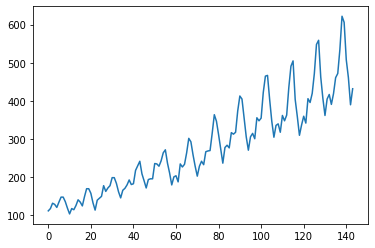

In [ ]:
# load the dataset
dataframe = read_csv('/content/AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

In [ ]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [ ]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints.
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...)
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])

    return np.array(x),np.array(y)

In [ ]:
seq_size = 10  # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.

In [ ]:
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [ ]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [ ]:
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images,
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 2s - loss: 0.0632 - val_loss: 0.3199 - 2s/epoch - 758ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0472 - val_loss: 0.2588 - 37ms/epoch - 12ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0340 - val_loss: 0.2031 - 35ms/epoch - 12ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0235 - val_loss: 0.1528 - 31ms/epoch - 10ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0156 - val_loss: 0.1094 - 31ms/epoch - 10ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0118 - val_loss: 0.0742 - 31ms/epoch - 10ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0098 - val_loss: 0.0505 - 35ms/epoch - 12ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0101 - val_loss: 0.0377 - 29ms/epoch - 10ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0108 - val_loss: 0.0330 - 35ms/epoch - 12ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0108 - val_loss: 0.0330 - 31ms/epoch - 10ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0099 - val_loss: 0.0357 - 32ms/epoch - 11ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0089 - val_loss: 0.0399 - 32ms/epoch - 11ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0081 -

In [ ]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 4ms/step


In [ ]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 18.29 RMSE


In [ ]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 42.60 RMSE


In [ ]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset.
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

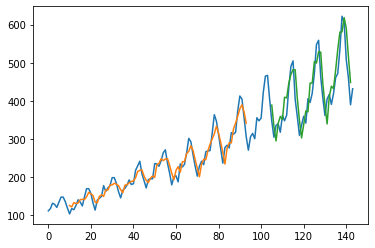

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()